In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns


In [2]:
df = pd.read_csv('C:/Users/samsung/Documents/CasePAN/credit/data/case_cientista_dados_PAN.txt', delimiter = ';')

In [3]:
df

,CLIENTE,DATA_FINANCIAMENTO,TARGET_M3OVER30,IDADE,ESTADO,RENDA,LIMITE_CARTAO,VALOR_FINANC_VEICULOS_ATUAL,SCORE_MERCADO,VALOR_VEICULO,ANO_VEICULO
0,0,2021-10,1,25.0,SP,4760.043944,21361.878421,0.000000,882.238536,"27802,51",2020.0
1,1,2021-11,1,27.0,CE,1700.000000,6551.924996,0.000000,956.692365,"34525,51",2020.0
2,2,2021-10,1,32.0,RJ,4004.147555,12831.296653,29246.823466,610.724337,"36178,14",2020.0
3,3,2021-12,1,39.0,CE,12250.000000,11252.113450,111621.080000,815.069341,"38681,99",2020.0
4,4,2021-12,0,38.0,RJ,1800.000000,11087.609068,0.000000,947.383539,"30742,18",2021.0
...,...,...,...,...,...,...,...,...,...,...,...
6995,4588,2021-11,1,37.0,SC,20728.584790,17490.004917,63571.250171,719.000000,"41896,12",2021.0
6996,6996,2021-10,0,27.0,SP,11780.381806,250.000000,0.000000,990.681716,"38848,43",2021.0
6997,6997,2021-10,0,24.0,SC,39445.186665,398.000000,0.000000,885.814411,"43202,45",2020.0
6998,6998,2021-10,0,45.0,SP,4800.000000,18081.477110,44415.298425,850.907405,"34693,58",2021.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CLIENTE                      7000 non-null   int64  
 1   DATA_FINANCIAMENTO           7000 non-null   object 
 2   TARGET_M3OVER30              7000 non-null   int64  
 3   IDADE                        6981 non-null   float64
 4   ESTADO                       7000 non-null   object 
 5   RENDA                        7000 non-null   float64
 6   LIMITE_CARTAO                6934 non-null   float64
 7   VALOR_FINANC_VEICULOS_ATUAL  6934 non-null   float64
 8   SCORE_MERCADO                6980 non-null   float64
 9   VALOR_VEICULO                6997 non-null   object 
 10  ANO_VEICULO                  6997 non-null   float64
dtypes: float64(6), int64(2), object(3)
memory usage: 601.7+ KB


In [5]:
df.describe()

,CLIENTE,TARGET_M3OVER30,IDADE,RENDA,LIMITE_CARTAO,VALOR_FINANC_VEICULOS_ATUAL,SCORE_MERCADO,ANO_VEICULO
count,7000.000000,7000.000000,6981.000000,7000.000000,6934.000000,6934.000000,6980.000000,6997.000000
mean,3447.344714,0.285714,43.056869,8213.636099,9038.877500,9010.338687,753.905403,2019.955838
std,2019.518927,0.451786,13.036693,7928.804191,16043.678523,24065.645965,164.039755,1.370968
min,0.000000,0.000000,19.000000,800.000000,0.000000,0.000000,1.462154,2011.000000
25%,1694.750000,0.000000,32.000000,2350.000000,1062.717500,0.000000,641.000000,2020.000000
50%,3434.500000,0.000000,42.000000,5510.253541,5427.814748,0.000000,773.831260,2020.000000
75%,5183.250000,1.000000,53.000000,11851.041243,12624.586563,0.000000,891.000000,2021.000000
max,6999.000000,1.000000,77.000000,106828.787747,709776.920000,367302.807884,999.999903,2021.000000


In [6]:
df.isnull().sum()

CLIENTE                         0
DATA_FINANCIAMENTO              0
TARGET_M3OVER30                 0
IDADE                          19
ESTADO                          0
RENDA                           0
LIMITE_CARTAO                  66
VALOR_FINANC_VEICULOS_ATUAL    66
SCORE_MERCADO                  20
VALOR_VEICULO                   3
ANO_VEICULO                     3
dtype: int64

In [7]:
porcentagem = (df.isnull().sum()/df.shape[0]).sort_values(ascending= True) * 100
df_nulos = pd.DataFrame(porcentagem, columns=['% de Nulos'])
df_nulos = df_nulos.sort_values(by='% de Nulos', ascending=False)
df_nulos

,% de Nulos
LIMITE_CARTAO,0.942857
VALOR_FINANC_VEICULOS_ATUAL,0.942857
SCORE_MERCADO,0.285714
IDADE,0.271429
VALOR_VEICULO,0.042857
ANO_VEICULO,0.042857
CLIENTE,0.000000
DATA_FINANCIAMENTO,0.000000
TARGET_M3OVER30,0.000000
ESTADO,0.000000


In [8]:
df = df.dropna()

In [9]:
df

,CLIENTE,DATA_FINANCIAMENTO,TARGET_M3OVER30,IDADE,ESTADO,RENDA,LIMITE_CARTAO,VALOR_FINANC_VEICULOS_ATUAL,SCORE_MERCADO,VALOR_VEICULO,ANO_VEICULO
0,0,2021-10,1,25.0,SP,4760.043944,21361.878421,0.000000,882.238536,"27802,51",2020.0
1,1,2021-11,1,27.0,CE,1700.000000,6551.924996,0.000000,956.692365,"34525,51",2020.0
2,2,2021-10,1,32.0,RJ,4004.147555,12831.296653,29246.823466,610.724337,"36178,14",2020.0
3,3,2021-12,1,39.0,CE,12250.000000,11252.113450,111621.080000,815.069341,"38681,99",2020.0
4,4,2021-12,0,38.0,RJ,1800.000000,11087.609068,0.000000,947.383539,"30742,18",2021.0
...,...,...,...,...,...,...,...,...,...,...,...
6995,4588,2021-11,1,37.0,SC,20728.584790,17490.004917,63571.250171,719.000000,"41896,12",2021.0
6996,6996,2021-10,0,27.0,SP,11780.381806,250.000000,0.000000,990.681716,"38848,43",2021.0
6997,6997,2021-10,0,24.0,SC,39445.186665,398.000000,0.000000,885.814411,"43202,45",2020.0
6998,6998,2021-10,0,45.0,SP,4800.000000,18081.477110,44415.298425,850.907405,"34693,58",2021.0


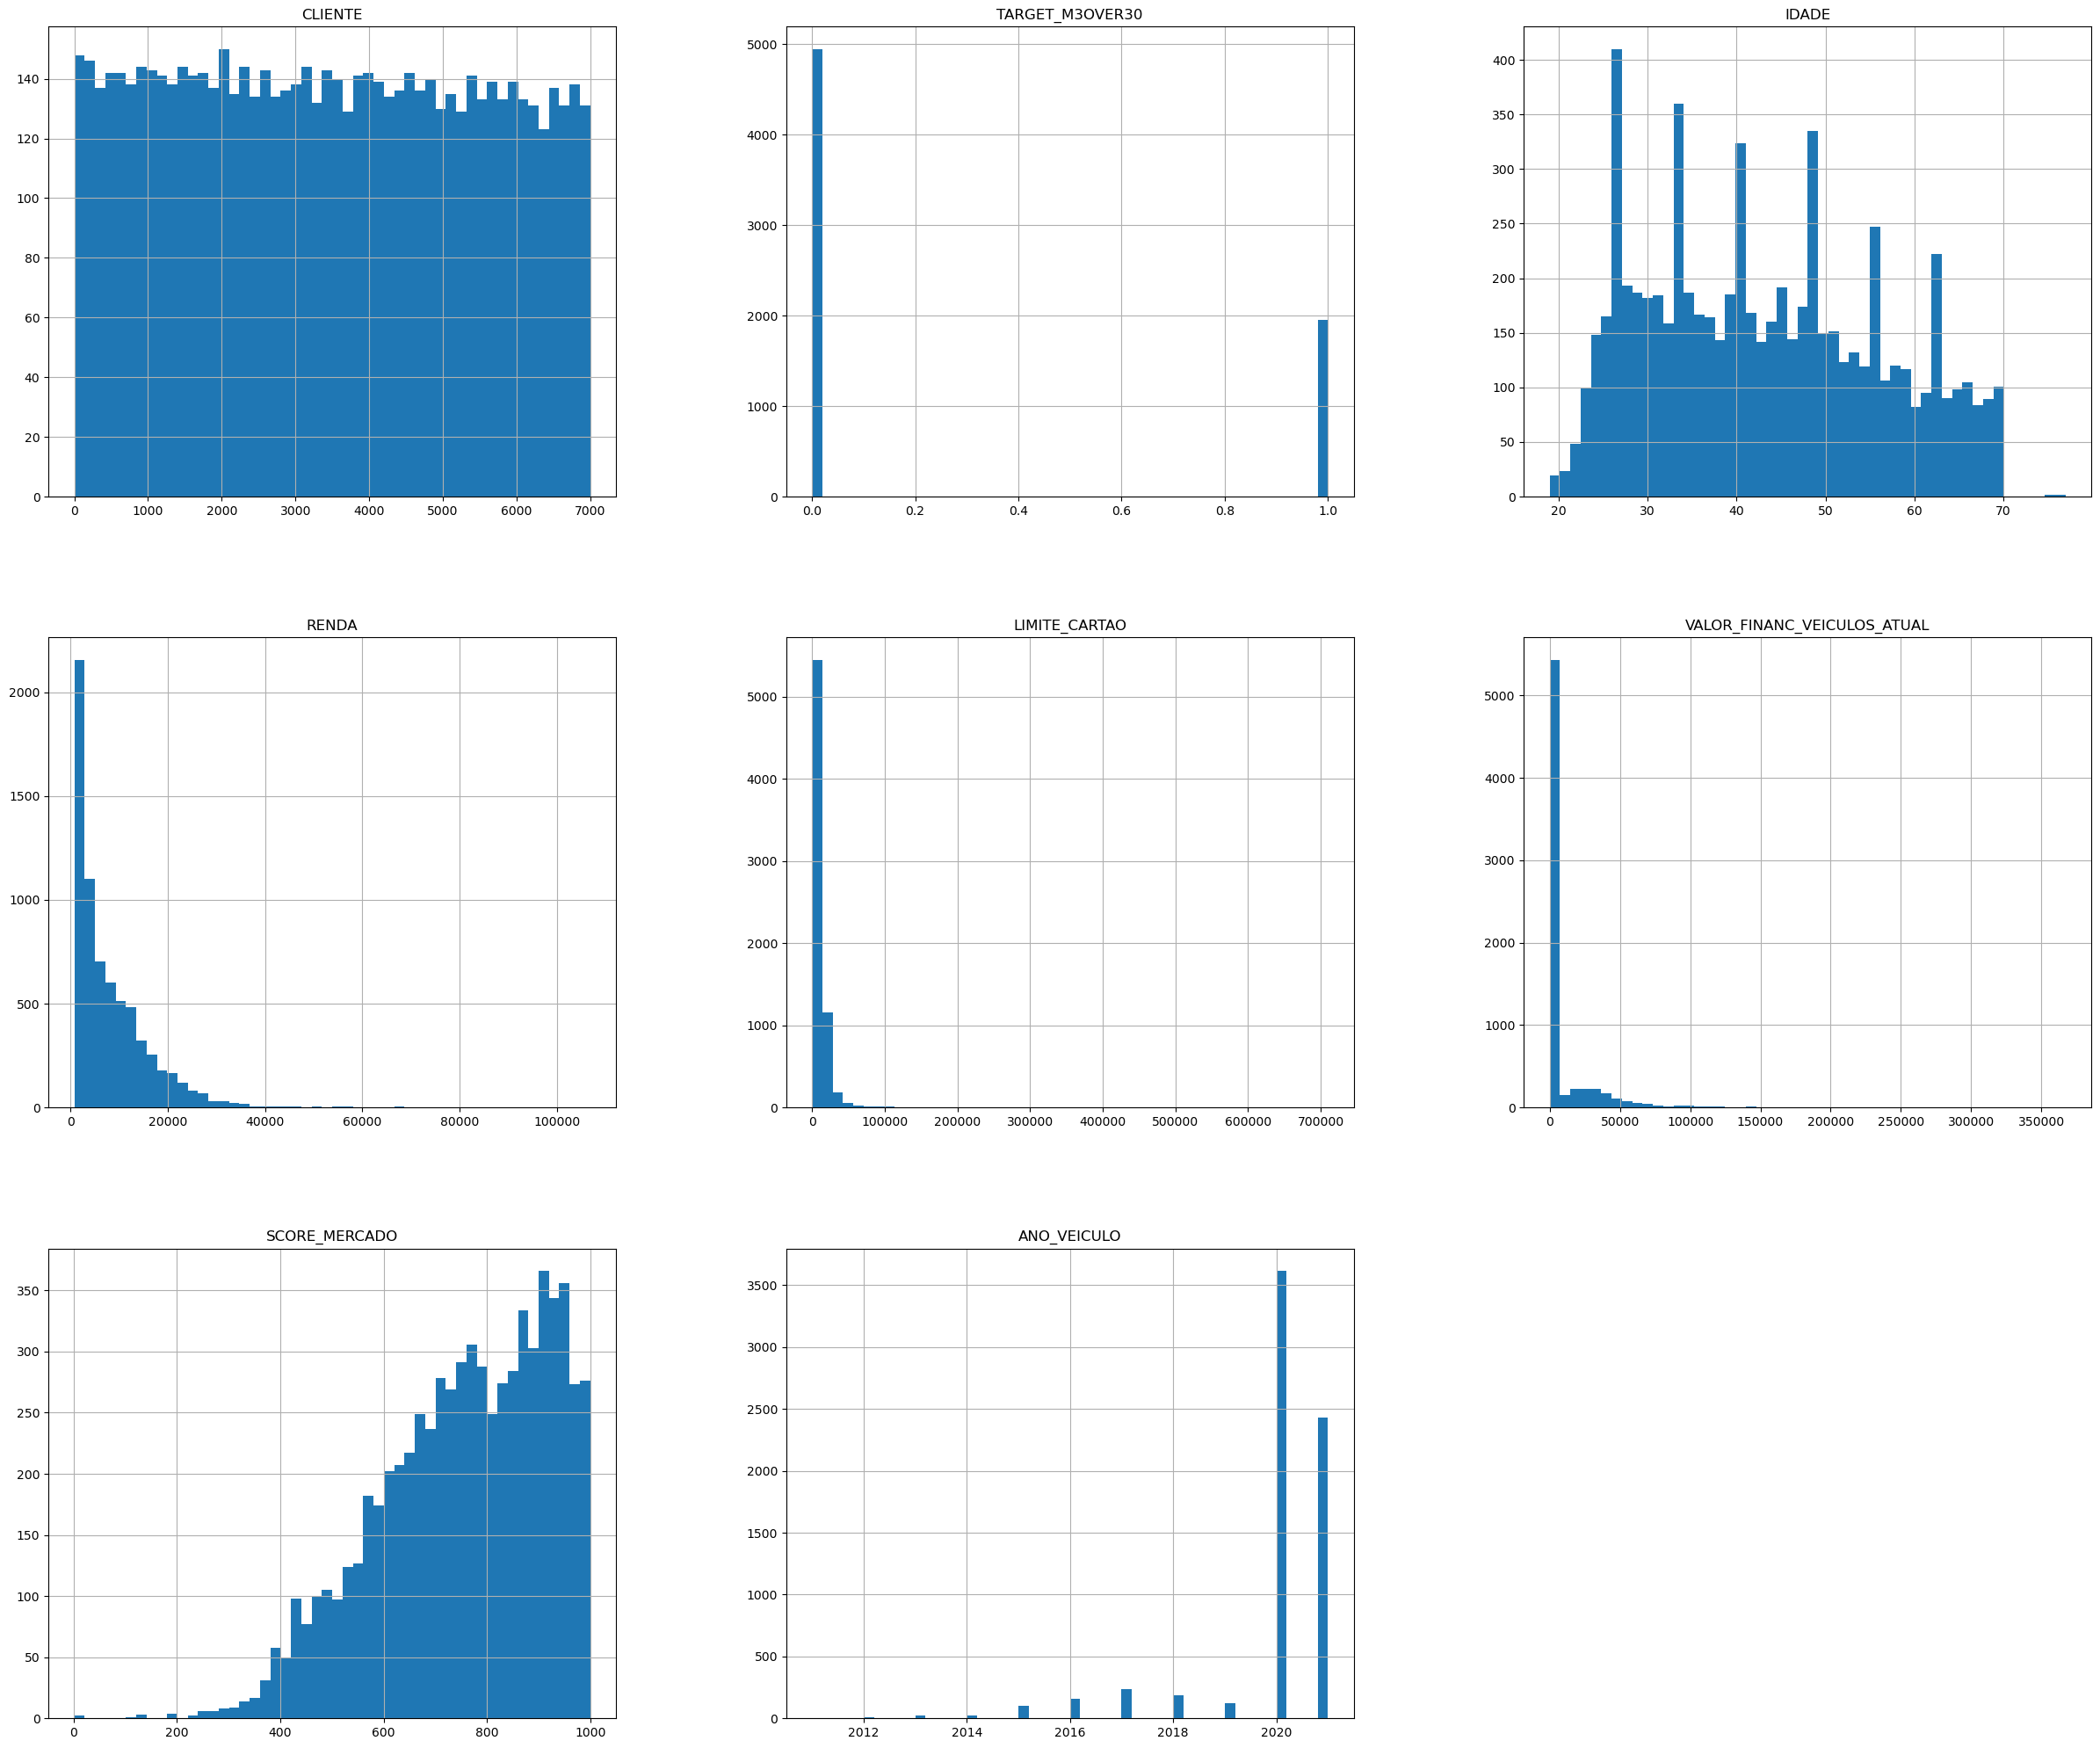

In [10]:
# histograma das variáveis da base de dados 
df.hist(bins=50, figsize=(30, 25))
plt.show()

c:\Users\samsung\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


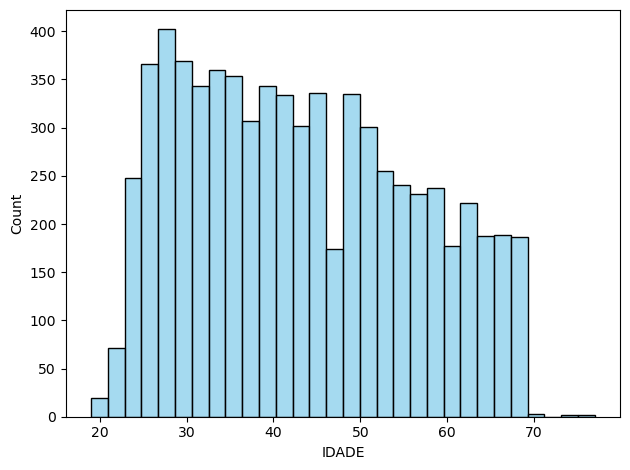

In [11]:
sns.histplot(df['IDADE'], bins=30, kde=False, color='skyblue')  # 30 bins pode ser ajustado
# Mostrar o gráfico
plt.tight_layout()
plt.show()

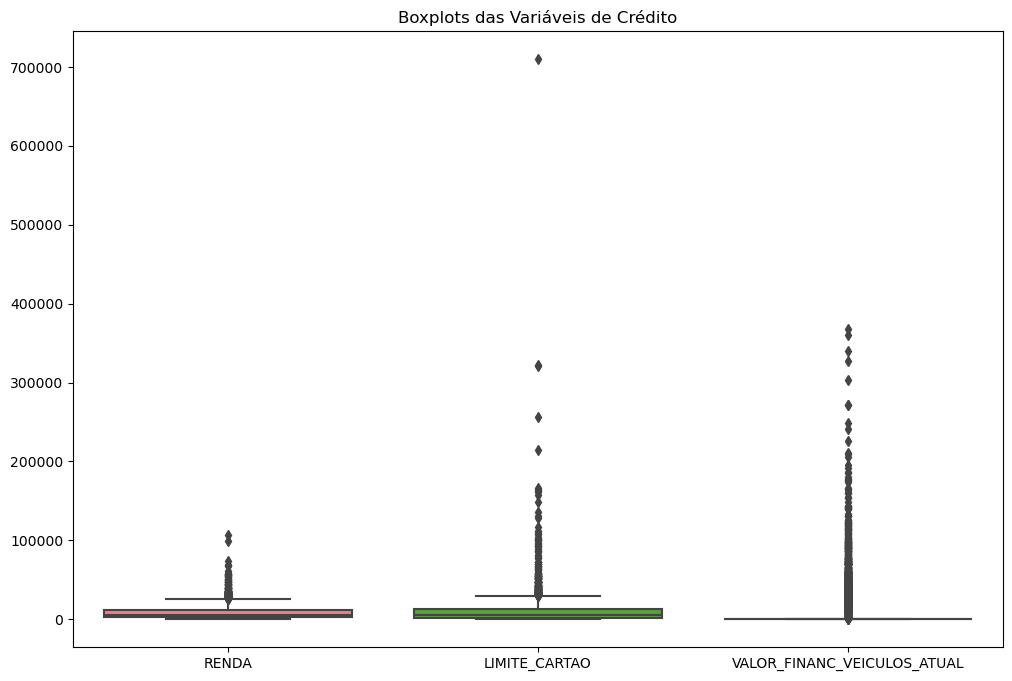

In [12]:
# Primeiro, criamos uma lista com os nomes das colunas
colunas = ['RENDA', 'LIMITE_CARTAO', 'VALOR_FINANC_VEICULOS_ATUAL', 'VALOR_VEICULO']

# Definindo o tamanho da figura
plt.figure(figsize=(12, 8))

# Plotando os boxplots em um único eixo (subplots)
sns.boxplot(data=df[colunas], palette='husl')

# Adicionando título
plt.title('Boxplots das Variáveis de Crédito')

# Exibindo o gráfico
plt.show()

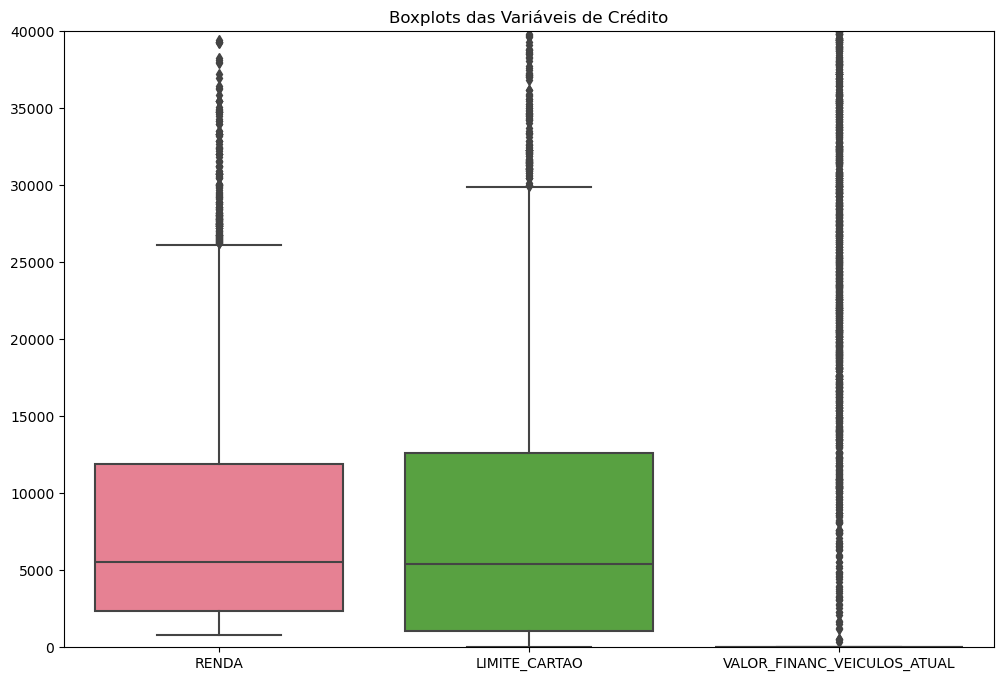

In [13]:
# Definindo o tamanho da figura
plt.figure(figsize=(12, 8))

# Plotando os boxplots
sns.boxplot(data=df[colunas], palette='husl')

# Ajustando o limite do eixo Y
plt.ylim(0, 40000)

# Adicionando título
plt.title('Boxplots das Variáveis de Crédito')

# Exibindo o gráfico
plt.show()

<Axes: >

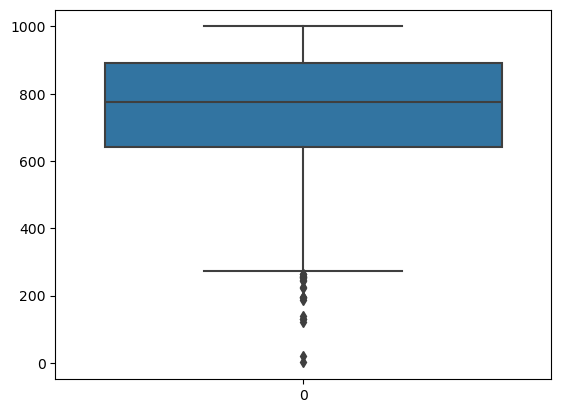

In [14]:
sns.boxplot(data=df['SCORE_MERCADO'])

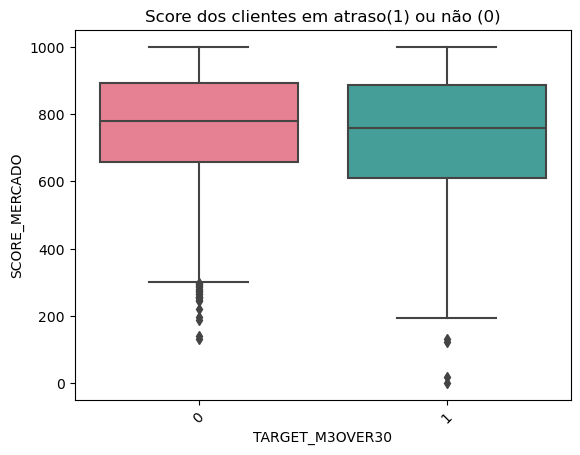

In [15]:
sns.boxplot(x='TARGET_M3OVER30', y='SCORE_MERCADO', data=df, palette='husl')
plt.title('Score dos clientes em atraso(1) ou não (0)')
plt.xticks(rotation=45)
plt.show()

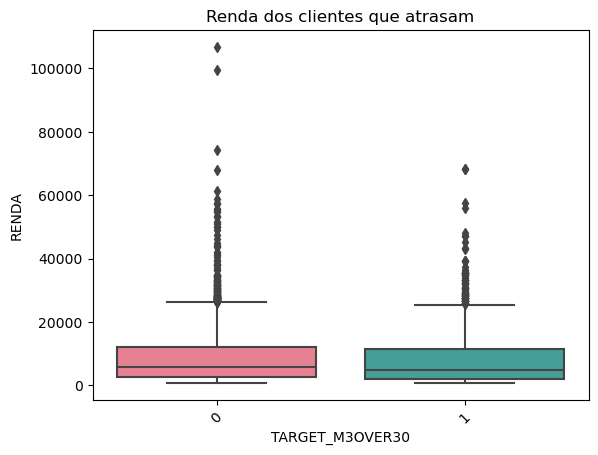

In [16]:
sns.boxplot(x='TARGET_M3OVER30', y='RENDA', data=df, palette='husl')
plt.title('Renda dos clientes que atrasam')
plt.xticks(rotation=45)
plt.show()

C:\Users\samsung\AppData\Local\Temp\ipykernel_1724\1923620855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TARGET_M3OVER30'] = df['TARGET_M3OVER30'].astype(int).astype(str)


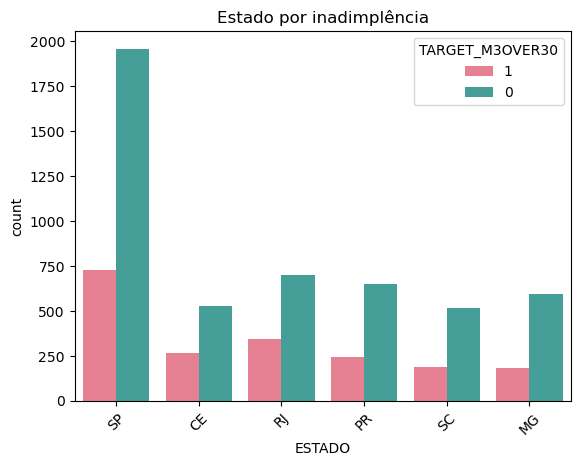

In [17]:
df['TARGET_M3OVER30'] = df['TARGET_M3OVER30'].astype(int).astype(str)

sns.countplot(x='ESTADO', hue='TARGET_M3OVER30', data=df, palette='husl')
plt.title('Estado por inadimplência')
plt.xticks(rotation=45)
plt.show()

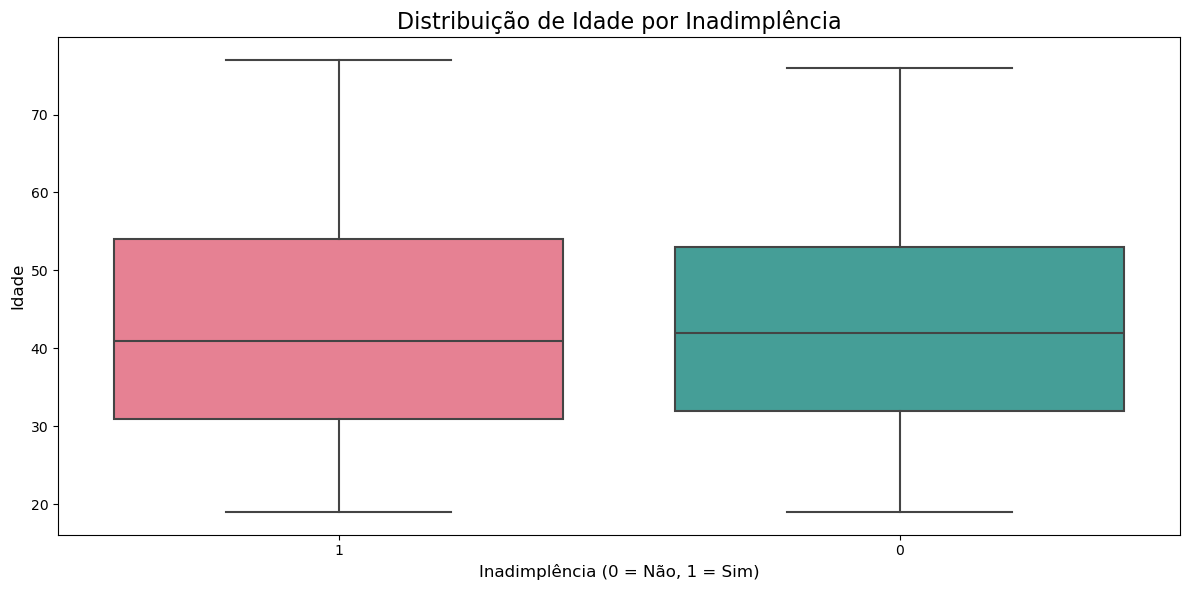

In [18]:
# Plotando o violin plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='TARGET_M3OVER30', y='IDADE', palette='husl')

# Ajustando título e rótulos
plt.title('Distribuição de Idade por Inadimplência', fontsize=16)
plt.xlabel('Inadimplência (0 = Não, 1 = Sim)', fontsize=12)
plt.ylabel('Idade', fontsize=12)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

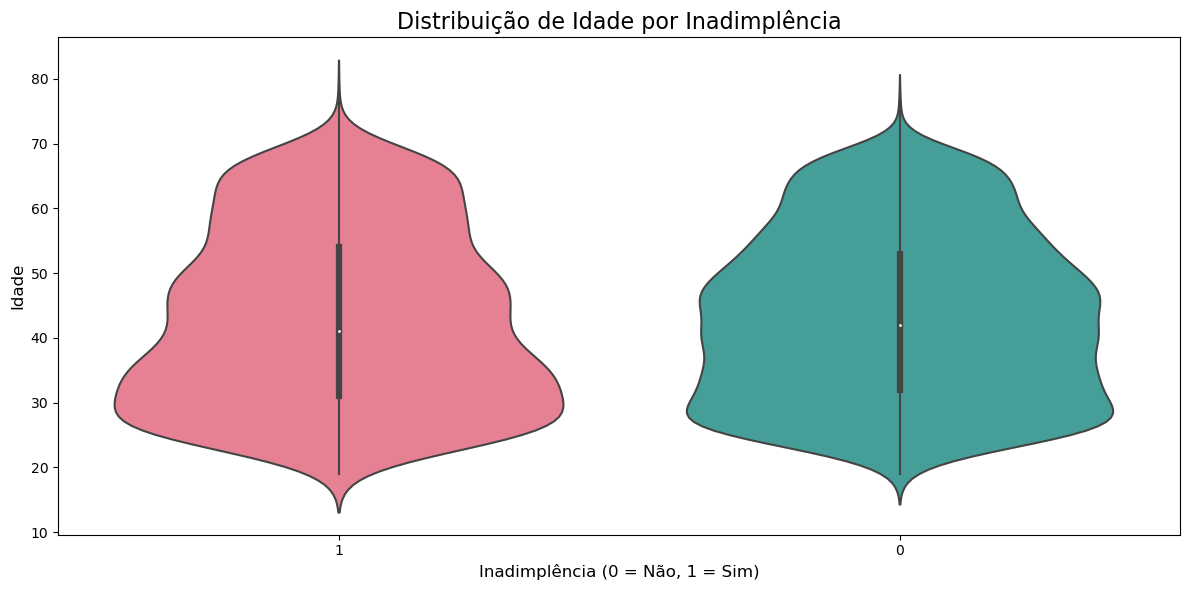

In [19]:
# Plotando o violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='TARGET_M3OVER30', y='IDADE', palette='husl')

# Ajustando título e rótulos
plt.title('Distribuição de Idade por Inadimplência', fontsize=16)
plt.xlabel('Inadimplência (0 = Não, 1 = Sim)', fontsize=12)
plt.ylabel('Idade', fontsize=12)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

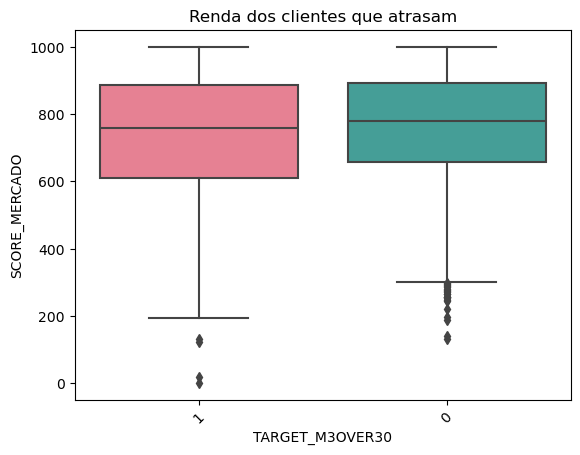

In [20]:
sns.boxplot(x='TARGET_M3OVER30', y='SCORE_MERCADO', data=df, palette='husl')
plt.title('Renda dos clientes que atrasam')
plt.xticks(rotation=45)
plt.show()

In [21]:
# Certificando-se de que a coluna DATA_FINANCIAMENTO está no formato datetime
df['DATA_FINANCIAMENTO'] = pd.to_datetime(df['DATA_FINANCIAMENTO'], errors='coerce')

# Verificando o tipo da coluna para garantir a conversão
print(df['DATA_FINANCIAMENTO'].dtype)

datetime64[ns]


C:\Users\samsung\AppData\Local\Temp\ipykernel_1724\2259946230.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DATA_FINANCIAMENTO'] = pd.to_datetime(df['DATA_FINANCIAMENTO'], errors='coerce')


In [22]:
from datetime import datetime

# Definir a data atual
hoje = datetime.now()

# Calcular a idade do financiamento em meses
df['IDADE_FINANCIAMENTO_MESES'] = ((hoje - df['DATA_FINANCIAMENTO']).dt.days) // 30

# Verificando os primeiros registros
print(df[['DATA_FINANCIAMENTO', 'IDADE_FINANCIAMENTO_MESES']].head())

  DATA_FINANCIAMENTO  IDADE_FINANCIAMENTO_MESES
0         2021-10-01                         38
1         2021-11-01                         37
2         2021-10-01                         38
3         2021-12-01                         36
4         2021-12-01                         36


C:\Users\samsung\AppData\Local\Temp\ipykernel_1724\419136890.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IDADE_FINANCIAMENTO_MESES'] = ((hoje - df['DATA_FINANCIAMENTO']).dt.days) // 30


In [23]:
# Verificar se há valores NaT na coluna
print(df['DATA_FINANCIAMENTO'].isnull().sum())

0


In [24]:
df['IDADE_FINANCIAMENTO_MESES'].unique()

array([38, 37, 36], dtype=int64)

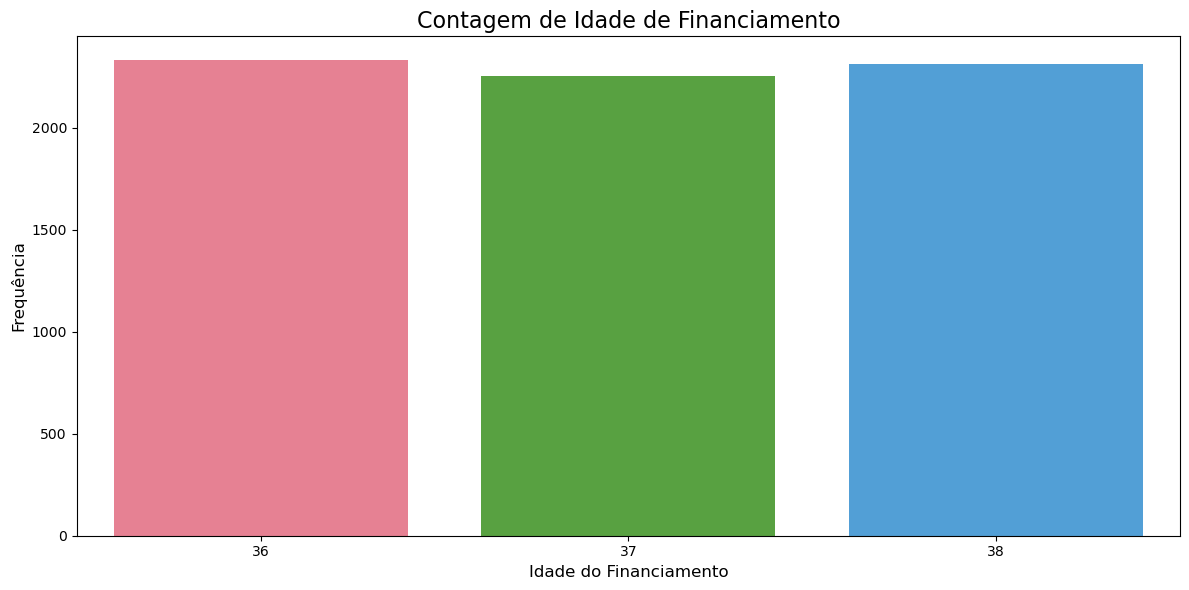

In [25]:
freq_finan = df['IDADE_FINANCIAMENTO_MESES'].value_counts()
# Plotando o gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=freq_finan.index, y=freq_finan.values, palette='husl')

# Ajustando título e rótulos
plt.title('Contagem de Idade de Financiamento', fontsize=16)
plt.xlabel('Idade do Financiamento', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

In [26]:
# Extrair o mês e o ano
df['MES_FINANCIAMENTO'] = df['DATA_FINANCIAMENTO'].dt.month
df['ANO_FINANCIAMENTO'] = df['DATA_FINANCIAMENTO'].dt.year

C:\Users\samsung\AppData\Local\Temp\ipykernel_1724\428353032.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MES_FINANCIAMENTO'] = df['DATA_FINANCIAMENTO'].dt.month
C:\Users\samsung\AppData\Local\Temp\ipykernel_1724\428353032.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ANO_FINANCIAMENTO'] = df['DATA_FINANCIAMENTO'].dt.year


In [27]:
df['ANO_FINANCIAMENTO'].unique()

array([2021])

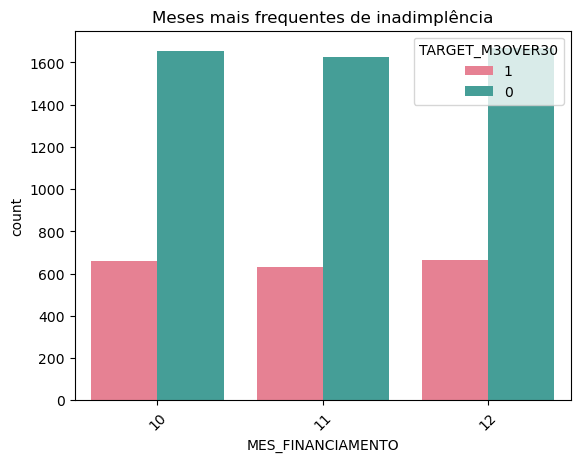

In [28]:
sns.countplot(x='MES_FINANCIAMENTO', hue='TARGET_M3OVER30', data=df, palette='husl')
plt.title('Meses mais frequentes de inadimplência')
plt.xticks(rotation=45)
plt.show()

In [29]:
df['VALOR_FINANC_VEICULOS_ATUAL'].value_counts()

VALOR_FINANC_VEICULOS_ATUAL
0.000000         5378
3288.570000         2
33145.400000        2
30751.499721        1
34530.718165        1
                 ... 
2290.156835         1
60390.231967        1
248429.079279       1
16621.543489        1
44415.298425        1
Name: count, Length: 1519, dtype: int64

In [30]:
df_zero_value = df[df['VALOR_FINANC_VEICULOS_ATUAL'] == 0]
print(df_zero_value.describe())

           CLIENTE             DATA_FINANCIAMENTO        IDADE          RENDA  \
count  5378.000000                           5378  5378.000000    5378.000000   
mean   3453.494050  2021-10-31 17:15:09.036816640    42.642246    7741.073408   
min       0.000000            2021-10-01 00:00:00    19.000000     800.000000   
25%    1732.500000            2021-10-01 00:00:00    31.000000    2100.000000   
50%    3438.500000            2021-11-01 00:00:00    41.000000    5121.945900   
75%    5169.750000            2021-12-01 00:00:00    53.000000   11344.430300   
max    6999.000000            2021-12-01 00:00:00    77.000000  106828.787747   
std    2008.654996                            NaN    13.230912    7500.668331   

       LIMITE_CARTAO  VALOR_FINANC_VEICULOS_ATUAL  SCORE_MERCADO  ANO_VEICULO  \
count    5378.000000                       5378.0    5378.000000  5378.000000   
mean     8225.056017                          0.0     751.585454  2019.990145   
min         0.000000       

In [31]:
df = df.drop('VALOR_FINANC_VEICULOS_ATUAL', axis=1)
df

,CLIENTE,DATA_FINANCIAMENTO,TARGET_M3OVER30,IDADE,ESTADO,RENDA,LIMITE_CARTAO,SCORE_MERCADO,VALOR_VEICULO,ANO_VEICULO,IDADE_FINANCIAMENTO_MESES,MES_FINANCIAMENTO,ANO_FINANCIAMENTO
0,0,2021-10-01,1,25.0,SP,4760.043944,21361.878421,882.238536,"27802,51",2020.0,38,10,2021
1,1,2021-11-01,1,27.0,CE,1700.000000,6551.924996,956.692365,"34525,51",2020.0,37,11,2021
2,2,2021-10-01,1,32.0,RJ,4004.147555,12831.296653,610.724337,"36178,14",2020.0,38,10,2021
3,3,2021-12-01,1,39.0,CE,12250.000000,11252.113450,815.069341,"38681,99",2020.0,36,12,2021
4,4,2021-12-01,0,38.0,RJ,1800.000000,11087.609068,947.383539,"30742,18",2021.0,36,12,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,4588,2021-11-01,1,37.0,SC,20728.584790,17490.004917,719.000000,"41896,12",2021.0,37,11,2021
6996,6996,2021-10-01,0,27.0,SP,11780.381806,250.000000,990.681716,"38848,43",2021.0,38,10,2021
6997,6997,2021-10-01,0,24.0,SC,39445.186665,398.000000,885.814411,"43202,45",2020.0,38,10,2021
6998,6998,2021-10-01,0,45.0,SP,4800.000000,18081.477110,850.907405,"34693,58",2021.0,38,10,2021


In [32]:
df['LIMITE_CARTAO'].value_counts()

LIMITE_CARTAO
0.000000        824
300.000000       11
0.010000          9
1200.000000       8
1000.000000       8
               ... 
1612.862924       1
6691.412036       1
1201.848997       1
4124.284435       1
18081.477110      1
Name: count, Length: 5700, dtype: int64

In [33]:
df['VALOR_VEICULO'] = df['VALOR_VEICULO'].str.replace(',', '.').astype(float)
 

In [34]:
df['VALOR_VEICULO']

0       27802.51
1       34525.51
2       36178.14
3       38681.99
4       30742.18
          ...   
6995    41896.12
6996    38848.43
6997    43202.45
6998    34693.58
6999    31147.91
Name: VALOR_VEICULO, Length: 6898, dtype: float64

In [35]:
df[['RENDA', 'LIMITE_CARTAO', 'SCORE_MERCADO', 'VALOR_VEICULO']].corr()

,RENDA,LIMITE_CARTAO,SCORE_MERCADO,VALOR_VEICULO
RENDA,1.000000,0.200665,0.014408,0.059969
LIMITE_CARTAO,0.200665,1.000000,0.063642,0.063262
SCORE_MERCADO,0.014408,0.063642,1.000000,0.000654
VALOR_VEICULO,0.059969,0.063262,0.000654,1.000000


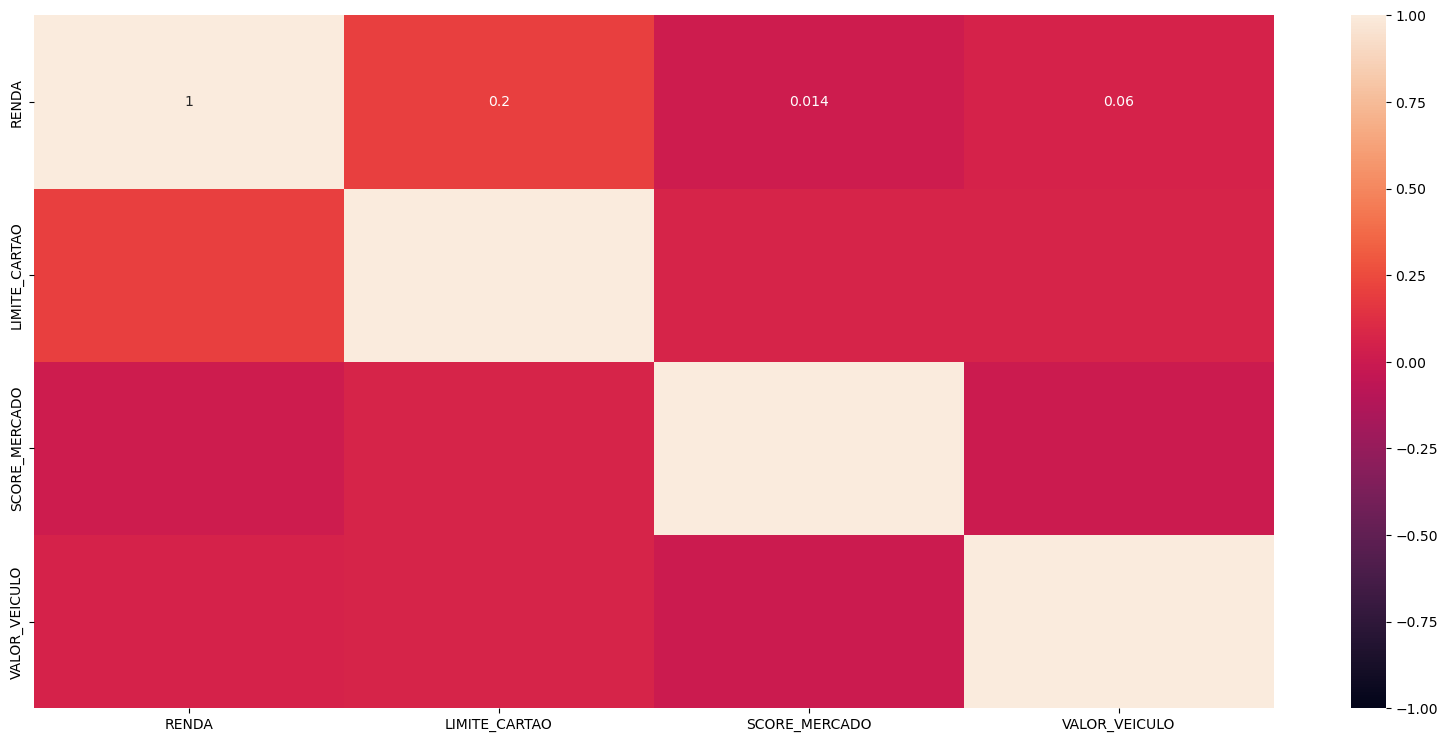

In [78]:
df_discrete = df[['RENDA', 'LIMITE_CARTAO', 'SCORE_MERCADO', 'VALOR_VEICULO']]
plt.figure(figsize=(20, 9))
heatmap = sns.heatmap(df_discrete.corr().abs(), 
                      vmin=-1, 
                      vmax=1, 
                      annot=True)

In [37]:
df

,CLIENTE,DATA_FINANCIAMENTO,TARGET_M3OVER30,IDADE,ESTADO,RENDA,LIMITE_CARTAO,SCORE_MERCADO,VALOR_VEICULO,ANO_VEICULO,IDADE_FINANCIAMENTO_MESES,MES_FINANCIAMENTO,ANO_FINANCIAMENTO
0,0,2021-10-01,1,25.0,SP,4760.043944,21361.878421,882.238536,27802.51,2020.0,38,10,2021
1,1,2021-11-01,1,27.0,CE,1700.000000,6551.924996,956.692365,34525.51,2020.0,37,11,2021
2,2,2021-10-01,1,32.0,RJ,4004.147555,12831.296653,610.724337,36178.14,2020.0,38,10,2021
3,3,2021-12-01,1,39.0,CE,12250.000000,11252.113450,815.069341,38681.99,2020.0,36,12,2021
4,4,2021-12-01,0,38.0,RJ,1800.000000,11087.609068,947.383539,30742.18,2021.0,36,12,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,4588,2021-11-01,1,37.0,SC,20728.584790,17490.004917,719.000000,41896.12,2021.0,37,11,2021
6996,6996,2021-10-01,0,27.0,SP,11780.381806,250.000000,990.681716,38848.43,2021.0,38,10,2021
6997,6997,2021-10-01,0,24.0,SC,39445.186665,398.000000,885.814411,43202.45,2020.0,38,10,2021
6998,6998,2021-10-01,0,45.0,SP,4800.000000,18081.477110,850.907405,34693.58,2021.0,38,10,2021


In [38]:
print(df['ESTADO'].unique())


['SP' 'CE' 'RJ' 'PR' 'SC' 'MG']


In [39]:
from sklearn.preprocessing import LabelEncoder

# Usando o LabelEncoder para transformar a coluna 'Estado'
encoder = LabelEncoder()
df['ESTADO_ENCODED'] = encoder.fit_transform(df['ESTADO'])


In [40]:
print(df[['ESTADO', 'ESTADO_ENCODED']].head(10))

  ESTADO  ESTADO_ENCODED
0     SP               5
1     CE               0
2     RJ               3
3     CE               0
4     RJ               3
5     SP               5
6     PR               2
7     RJ               3
8     SP               5
9     SC               4


In [41]:
df['TARGET_M3OVER30'] = df['TARGET_M3OVER30'].astype(int)


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6898 entries, 0 to 6999
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   CLIENTE                    6898 non-null   int64         
 1   DATA_FINANCIAMENTO         6898 non-null   datetime64[ns]
 2   TARGET_M3OVER30            6898 non-null   int32         
 3   IDADE                      6898 non-null   float64       
 4   ESTADO                     6898 non-null   object        
 5   RENDA                      6898 non-null   float64       
 6   LIMITE_CARTAO              6898 non-null   float64       
 7   SCORE_MERCADO              6898 non-null   float64       
 8   VALOR_VEICULO              6898 non-null   float64       
 9   ANO_VEICULO                6898 non-null   float64       
 10  IDADE_FINANCIAMENTO_MESES  6898 non-null   int64         
 11  MES_FINANCIAMENTO          6898 non-null   int32         
 12  ANO_FINANCI

In [43]:
# contagem de valores das classes da variável alvo 
print(f"A base de dados possui {df[df['TARGET_M3OVER30']==0].shape[0]} registros com classe 0 e {df[df['TARGET_M3OVER30']==1].shape[0]} na classe 1")
print(f"Porcentagem de dados na classe 0: {np.round(df[df['TARGET_M3OVER30']==0].shape[0]/(df.shape[0]),2)}")
print(f"Porcentagem de dados na classe 1: {np.round(df[df['TARGET_M3OVER30']==1].shape[0]/(df.shape[0]),2)}")

A base de dados possui 4944 registros com classe 0 e 1954 na classe 1
Porcentagem de dados na classe 0: 0.72
Porcentagem de dados na classe 1: 0.28


## TREINO E TESTE

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6898 entries, 0 to 6999
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   CLIENTE                    6898 non-null   int64         
 1   DATA_FINANCIAMENTO         6898 non-null   datetime64[ns]
 2   TARGET_M3OVER30            6898 non-null   int32         
 3   IDADE                      6898 non-null   float64       
 4   ESTADO                     6898 non-null   object        
 5   RENDA                      6898 non-null   float64       
 6   LIMITE_CARTAO              6898 non-null   float64       
 7   SCORE_MERCADO              6898 non-null   float64       
 8   VALOR_VEICULO              6898 non-null   float64       
 9   ANO_VEICULO                6898 non-null   float64       
 10  IDADE_FINANCIAMENTO_MESES  6898 non-null   int64         
 11  MES_FINANCIAMENTO          6898 non-null   int32         
 12  ANO_FINANCI

In [45]:
X = df[['IDADE', 'RENDA', 'LIMITE_CARTAO', 'SCORE_MERCADO', 'VALOR_VEICULO', 'IDADE_FINANCIAMENTO_MESES', 'ESTADO_ENCODED']]
y = df['TARGET_M3OVER30']

In [46]:
X.describe()

,IDADE,RENDA,LIMITE_CARTAO,SCORE_MERCADO,VALOR_VEICULO,IDADE_FINANCIAMENTO_MESES,ESTADO_ENCODED
count,6898.000000,6898.000000,6898.000000,6898.000000,6898.000000,6898.000000,6898.000000
mean,43.115251,8238.090355,9027.895528,754.572105,40131.138388,36.997246,3.183097
std,13.021799,7949.645174,16065.667970,163.730261,7465.196000,0.820478,1.799576
min,19.000000,800.000000,0.000000,1.462154,16108.130000,36.000000,0.000000
25%,32.000000,2350.000000,1058.153346,641.000000,34979.967500,36.000000,2.000000
50%,42.000000,5550.000000,5422.618532,775.000000,39771.355000,37.000000,3.000000
75%,53.000000,11875.311412,12592.439606,891.072137,44714.402500,38.000000,5.000000
max,77.000000,106828.787747,709776.920000,999.999903,97177.920000,38.000000,5.000000


In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [49]:
# Inicializar o StandardScaler
scaler = StandardScaler()

# Ajustar e transformar os dados de treino
X_train_scaled = scaler.fit_transform(X_train)

# Transformar os dados de teste 
X_test_scaled = scaler.transform(X_test)

In [50]:
# Verificar as primeiras linhas dos dados padronizados
print(X_train_scaled[:5])

[[ 1.06823744  0.77140969  0.50759709  0.3602222   0.66330944 -0.00286665
   1.00394026]
 [-1.00619359 -0.87944556 -0.63174707  0.84387577 -0.64345338  1.2139158
   0.44690231]
 [ 0.76091432  0.02510227 -0.59630487 -0.14777644 -1.77473596 -0.00286665
  -1.78124945]
 [-1.08302437  0.17700106  0.80392797  0.41543606  0.81415332  1.2139158
   1.00394026]
 [ 1.14506822  0.35243157 -0.45757185  1.4444894   0.41873966 -0.00286665
   1.00394026]]


## Modelos

### Regressão Logística

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

logreg = LogisticRegression(random_state=42, class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

In [52]:
print("Avaliação da Regressão Logística:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_logreg):.4f}")
print(f"Matriz de Confusão:\n{confusion_matrix(y_test, y_pred_logreg)}")
print(f"Relatório de Classificação:\n{classification_report(y_test, y_pred_logreg)}")

Avaliação da Regressão Logística:
Acurácia: 0.5319
Matriz de Confusão:
[[560 439]
 [207 174]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.73      0.56      0.63       999
           1       0.28      0.46      0.35       381

    accuracy                           0.53      1380
   macro avg       0.51      0.51      0.49      1380
weighted avg       0.61      0.53      0.56      1380



### Árvore de Decisão

In [53]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

In [54]:
print("Avaliação da Árvore de Decisão:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_tree):.4f}")
print(f"Matriz de Confusão:\n{confusion_matrix(y_test, y_pred_tree)}")
print(f"Relatório de Classificação:\n{classification_report(y_test, y_pred_tree)}")

Avaliação da Árvore de Decisão:
Acurácia: 0.6254
Matriz de Confusão:
[[721 278]
 [239 142]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.75      0.72      0.74       999
           1       0.34      0.37      0.35       381

    accuracy                           0.63      1380
   macro avg       0.54      0.55      0.55      1380
weighted avg       0.64      0.63      0.63      1380



### Random Forest

In [72]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=200, max_depth=10)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [73]:
print("Avaliação do Random Forest:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Matriz de Confusão:\n{confusion_matrix(y_test, y_pred_rf)}")
print(f"Relatório de Classificação:\n{classification_report(y_test, y_pred_rf)}")

Avaliação do Random Forest:
Acurácia: 0.7196
Matriz de Confusão:
[[878 121]
 [266 115]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       999
           1       0.49      0.30      0.37       381

    accuracy                           0.72      1380
   macro avg       0.63      0.59      0.60      1380
weighted avg       0.69      0.72      0.70      1380



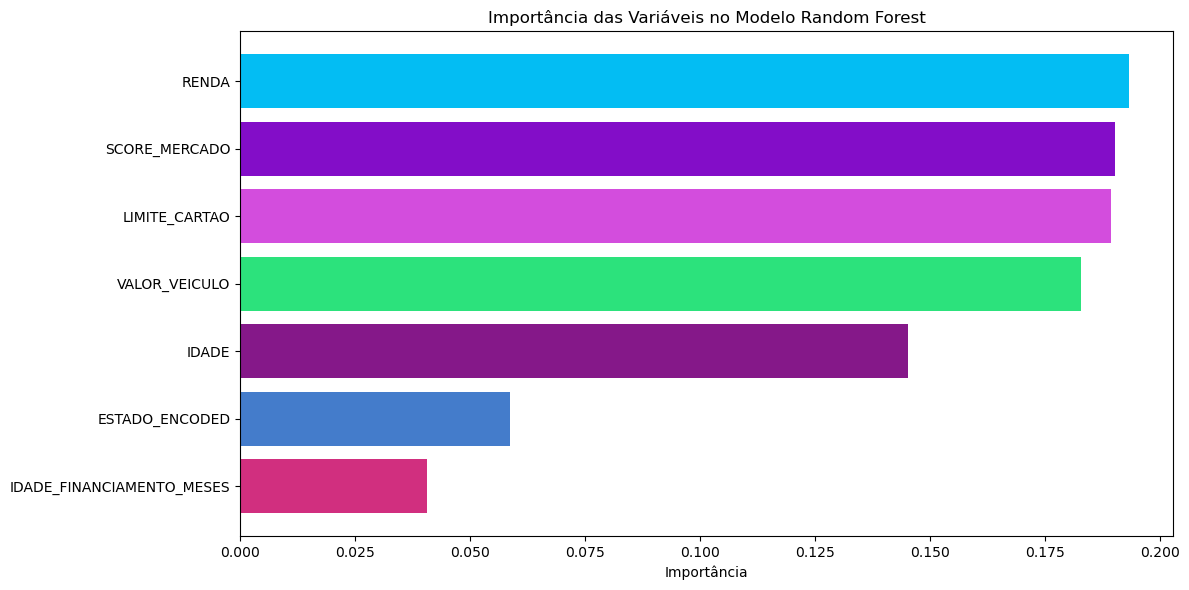

In [67]:
# Obtendo as importâncias das variáveis
importances = rf.feature_importances_

# Ordenando as importâncias
indices = importances.argsort()

# Gerando cores diferentes para cada barra (usando uma colormap)
colors = np.random.rand(len(importances), 3)

# Plotando as importâncias das variáveis com cores diferentes
plt.figure(figsize=(12, 6))
plt.barh(X_train.columns[indices], importances[indices], color=colors)
plt.xlabel('Importância')
plt.title('Importância das Variáveis no Modelo Random Forest')

# Ajustando o layout
plt.tight_layout()
plt.show()

### XGBoost

In [57]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [58]:
print("Avaliação do XGBoost:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Matriz de Confusão:\n{confusion_matrix(y_test, y_pred_xgb)}")
print(f"Relatório de Classificação:\n{classification_report(y_test, y_pred_xgb)}")

Avaliação do XGBoost:
Acurácia: 0.6928
Matriz de Confusão:
[[884 115]
 [309  72]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.74      0.88      0.81       999
           1       0.39      0.19      0.25       381

    accuracy                           0.69      1380
   macro avg       0.56      0.54      0.53      1380
weighted avg       0.64      0.69      0.65      1380



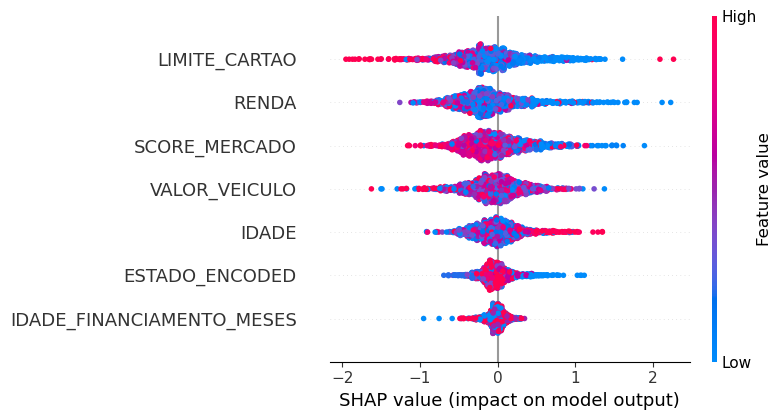

In [81]:
import shap

# Criando o objeto SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Calculando os SHAP values para o conjunto de teste
shap_values = explainer.shap_values(X_test)

# Plotando o gráfico de resumo dos SHAP values
shap.summary_plot(shap_values, X_test)

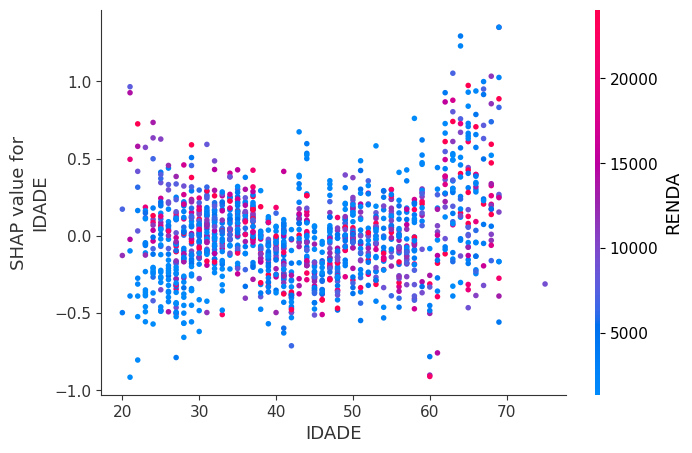

In [84]:
shap.dependence_plot("IDADE", shap_values, X_test)


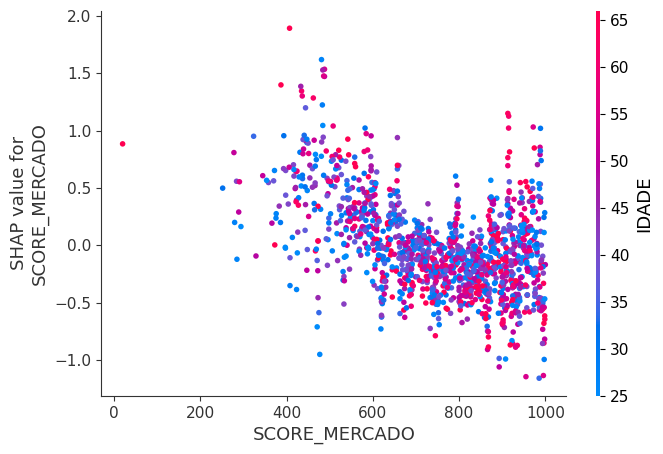

In [86]:
shap.dependence_plot("SCORE_MERCADO", shap_values, X_test)


### Light GBM

In [59]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

[LightGBM] [Info] Number of positive: 1573, number of negative: 3945
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 5518, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285067 -> initscore=-0.919464
[LightGBM] [Info] Start training from score -0.919464


In [60]:
print("Avaliação do LightGBM:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_lgb):.4f}")
print(f"Matriz de Confusão:\n{confusion_matrix(y_test, y_pred_lgb)}")
print(f"Relatório de Classificação:\n{classification_report(y_test, y_pred_lgb)}")

Avaliação do LightGBM:
Acurácia: 0.7203
Matriz de Confusão:
[[943  56]
 [330  51]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.74      0.94      0.83       999
           1       0.48      0.13      0.21       381

    accuracy                           0.72      1380
   macro avg       0.61      0.54      0.52      1380
weighted avg       0.67      0.72      0.66      1380

